## This code identifies candidate based on the given cluster dictionaries and the generated bipartite network

In [1]:
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, auc
import json
from networkx.algorithms import bipartite

In [2]:
# Get cluster information by reading the JSON string from the .txt file
with open('cluster_dictionaries.txt', 'r') as file:
    json_data = file.read()

# Convert the JSON string back to a dictionary
cluster_dictionaries = json.loads(json_data)

# Extract individual dictionaries
cluster_dict_all_descriptor = cluster_dictionaries['cluster_dict_all_descriptor']
cluster_dict_nbo_descriptor = cluster_dictionaries['cluster_dict_nbo_descriptor']
cluster_dict_vbur_descriptor = cluster_dictionaries['cluster_dict_vbur_descriptor']

# Print the dictionaries to verify
print("cluster_dict_all_descriptor:", cluster_dict_all_descriptor)
print("cluster_dict_nbo_descriptor:", cluster_dict_nbo_descriptor)
print("cluster_dict_vbur_descriptor:", cluster_dict_vbur_descriptor)

# Get the number of items for each dictionary
count_all_descriptor = len(cluster_dict_all_descriptor)
count_nbo_descriptor = len(cluster_dict_nbo_descriptor)
count_vbur_descriptor = len(cluster_dict_vbur_descriptor)

# Print the counts
print(f"Number of items in 'cluster_dict_all_descriptor': {count_all_descriptor}")
print(f"Number of items in 'cluster_dict_nbo_descriptor': {count_nbo_descriptor}")
print(f"Number of items in 'cluster_dict_vbur_descriptor': {count_vbur_descriptor}")


# Function to count the number of items in each dictionary and the number of strings in the lists
def count_items_in_dict(dictionary):
    for key, value in dictionary.items():
        list_length = len(value)  # Count the number of strings in the list
        print(f"Key: {key}, Number of strings: {list_length}")

# Count for each dictionary
print("For cluster_dict_all_descriptor:")
count_items_in_dict(cluster_dict_all_descriptor)

print("\nFor cluster_dict_nbo_descriptor:")
count_items_in_dict(cluster_dict_nbo_descriptor)

print("\nFor cluster_dict_vbur_descriptor:")
count_items_in_dict(cluster_dict_vbur_descriptor)

# Extract a list of 'd_nodes that are from dft calculations
dft_ligand_ids = []

# Iterate through the dictionary and collect all ligand_ids
for cluster, ligand_ids in cluster_dict_all_descriptor.items():
    dft_ligand_ids.extend(ligand_ids)

# Print the amount of all ligand_ids
num_dft_ligand_ids = len(dft_ligand_ids)
print(num_dft_ligand_ids)

cluster_dict_all_descriptor: {'c1': ['004', '005', '006', '007', '009', '013', '014', '015', '016', '027', '029', '033', '048', '053', '080', '081', '082', '091', '093', '095', '097', '100', '107', '120', '124', '131', '135', '137', '138', '139', '140', '142', '143', '144', '189', '192', '195', '233', '234', '242', '243', '245', '246', '249', '260', '261', '262', '267', '268', '271', '273', '277', '278', '286', '289', '290', '291', '292', '293', '324', '328', '368', '370', '390', '398', '406', '407', '408', '410', '422', '430', '441', '442', '444', '445', '446', '447', '448', '449', '461', '466', '467', '471'], 'c2': ['038', '072', '073', '074', '075', '076', '077', '078', '092', '099', '111', '121', '122', '145', '146', '149', '150', '151', '160', '161', '168', '169', '170', '171', '172', '173', '174', '177', '178', '179', '180', '181', '182', '183', '186', '199', '200', '201', '202', '205', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22

In [14]:
# File name of the Excel document containing the ligand dataset
file_name = 'master_ligand_dataset_3.csv'

# Read the Excel file
df = pd.read_csv(file_name)
df = df.dropna(how='all') # Remove rows where all values are NaN 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['lig_id'] = df['lig_id'].astype(int)


In [15]:
df

lig_id ligand_name                                             SMILES  \
0          1       n-n-1                                       CN(CCN(C)C)C   
1          1       n-n-1                                       CN(CCN(C)C)C   
2          2       p-p-1  P(CCP(C1=CC=CC=C1)C2=CC=CC=C2)(C3=CC=CC=C3)C4=...   
3          2       p-p-1  P(CCP(C1=CC=CC=C1)C2=CC=CC=C2)(C3=CC=CC=C3)C4=...   
4          3       p-p-2  P(CCCP(C1=CC=CC=C1)C2=CC=CC=C2)(C3=CC=CC=C3)C4...   
...      ...         ...                                                ...   
2054     471     p-o-168       [O-]C1=C(C(C)(C)C)C=CC=C1P(C2CCCCC2)C3CCCCC3   
2055     472     p-o-169  [O-]C1=C2C(C=CC=C2)=CC=C1P(C3=CC=CC=C3)C4=CC=C...   
2056     473     p-o-170      O=S(C1=CC=CC=C1P(C2=CC=CC=C2)C3CCCCC3)([O])=O   
2057     187      p-o-54         O=S(C1=CC=CC=C1P(C2CCCCC2)C3CCCCC3)([O])=O   
2058     251      p-o-66               O=S(C1=CC=CC=C1P(C(C)C)C(C)C)([O])=O   

     exp_id                                ref substrate_comb metal  \
0         1  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
1         2  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
2         3  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
3         4  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
4         5  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
...     ...                                ...            ...   ...   
2054   2066        Science 374, 604–607 (2021)            NaN    Ni   
2055   2067        Science 374, 604–607 (2021)            NaN    Ni   
2056   2068  Eur. Polym. J. 2024, 210, 113007.            NaN    Pd   
2057   2069  Eur. Polym. J. 2024, 210, 113007.            NaN    Pd   
2058   2070  Eur. Polym. J. 2024, 210, 113007.            NaN    Pd   

     substrate_1 substrate_2  solvent  ...  additive  additive_equiv  \
0            CO2    ethylene      dcm  ...      ch3i              10   
1            CO2    ethylene      dcm  ...      ch3i             100   
2            CO2    ethylene      dcm  ...      ch3i              10   
3            CO2    ethylene      dcm  ...      ch3i             100   
4            CO2    ethylene      dcm  ...      ch3i              10   
...          ...         ...      ...  ...       ...             ...   
2054    ethylene   CO_nonalt  toluene  ...       NaN             NaN   
2055    ethylene   CO_nonalt  toluene  ...       NaN             NaN   
2056    ethylene   CO_nonalt      dcm  ...       NaN             NaN   
2057    ethylene   CO_nonalt      dcm  ...       NaN             NaN   
2058    ethylene   CO_nonalt      dcm  ...       NaN             NaN   

     substrate_ratio volume_ml  activity_kg_mol yield     mn  time_hr  \
0                NaN       4.0              NaN  21.0    NaN      3.0   
1                NaN       4.0              NaN  56.0    NaN      3.0   
2                NaN       4.0              NaN  14.0    NaN     48.0   
3                NaN       4.0              NaN  29.0    NaN     48.0   
4                NaN       4.0              NaN  18.0    NaN     24.0   
...              ...       ...              ...   ...    ...      ...   
2054             NaN     100.0              NaN   NaN  45000      2.0   
2055             NaN     100.0              NaN   NaN  90000      2.0   
2056             NaN      20.0             24.0   NaN   77.2      1.0   
2057             NaN      20.0             29.8   NaN  103.3      1.0   
2058             NaN      20.0             24.5   NaN   77.3      1.0   

      incorporatio_ratio  ton  
0                    NaN  NaN  
1                    NaN  NaN  
2                    NaN  NaN  
3                    NaN  NaN  
4                    NaN  NaN  
...                  ...  ...  
2054                 NaN  NaN  
2055                 NaN  NaN  
2056                12.2  NaN  
2057                17.5  NaN  
2058                12.1  NaN  

[2059 rows x 25 columns]

In [16]:
# Filter the DataFrame for rows where substrate_1 is 'CO2'
filtered_df = df[df['substrate_1'] == 'CO2']

# Get unique lig_id values
unique_lig_ids = filtered_df['lig_id'].unique()

# Convert to list (if needed)
unique_lig_ids_list = unique_lig_ids.tolist()

print(unique_lig_ids_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 71, 72, 14, 15, 16, 17, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 64, 65, 66, 67, 68, 69, 70, 44, 410]


In [59]:
columns_of_interest = ['ligand_name','lig_id','substrate_1','substrate_2']
lig_rxn_df = df[columns_of_interest]
# Convert 'lig_id' to string with leading zeros
lig_rxn_df['lig_id'] = lig_rxn_df['lig_id'].apply(lambda x: f"{x:03}")

# Identify rows to remove from lig_rxn_df
removed_ligand_ids = lig_rxn_df.loc[~lig_rxn_df['lig_id'].isin(dft_ligand_ids), 'lig_id'].tolist()
print("Experimental Ligand ids not calculated:", set(removed_ligand_ids))

# If lig_id from this experimental dataframe isn't in the dft_lig_id list, please remove row
lig_rxn_df = lig_rxn_df[lig_rxn_df['lig_id'].isin(dft_ligand_ids)]

unique_lig_ids_df = set(lig_rxn_df['lig_id'].unique())
print('Updated number for number of experimental ligand ids', len(unique_lig_ids_df))
unique_dft_ligand_ids = set(dft_ligand_ids)
# assert len(unique_lig_ids_df) == len(unique_dft_ligand_ids), f"Mismatch in unique lig_id counts: ligand-id has {len(unique_lig_ids_df)}, DFT-ligand_list has {len(unique_dft_ligand_ids)}"


# Update the cluster dictionaries by keeping only those ligand_ids present in unique_lig_ids_set
updated_cluster_dict_all_descriptor = {
    cluster: [lig_id for lig_id in ligand_ids if lig_id in unique_lig_ids_df]
    for cluster, ligand_ids in cluster_dict_all_descriptor.items()
}

updated_cluster_dict_vbur_descriptor = {
    cluster: [lig_id for lig_id in ligand_ids if lig_id in unique_lig_ids_df]
    for cluster, ligand_ids in cluster_dict_vbur_descriptor.items()
}

updated_cluster_dict_nbo_descriptor = {
    cluster: [lig_id for lig_id in ligand_ids if lig_id in unique_lig_ids_df]
    for cluster, ligand_ids in cluster_dict_nbo_descriptor.items()
}

# Re-extract a list of 'd_nodes' that are from dft calculations
updated_dft_ligand_ids = []

# Iterate through the dictionary and collect all ligand_ids
for cluster, ligand_ids in updated_cluster_dict_nbo_descriptor.items():
    updated_dft_ligand_ids.extend(ligand_ids)

# Print the amount of all ligand_ids
updated_num_dft_ligand_ids = len(updated_dft_ligand_ids)
print('Updated number for number of dft ligand ids', updated_num_dft_ligand_ids)

# Compare updated and original dft list of ligand ids, show me a list of ids that are not in both:
updated_unique_dft_ligand_ids = set(updated_dft_ligand_ids)
difference = list(updated_unique_dft_ligand_ids.symmetric_difference(unique_dft_ligand_ids))
# Print the result
print("DFT ligand ids not included in updated lists:", difference)

lig_rxn_df = lig_rxn_df.drop_duplicates()
lig_rxn_df

Experimental Ligand ids not calculated: {'028', '470', '070', '024', '061', '065', '067', '001', '025', '185', '469', '050', '068', '023', '049', '063', '069', '473', '066', '052', '051', '062', '064', '026', '034', '012'}
Updated number for number of experimental ligand ids 437
Updated number for number of dft ligand ids 437
DFT ligand ids not included in updated lists: ['037', nan]


C:\Users\George\AppData\Local\Temp\ipykernel_82624\676133896.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lig_rxn_df['lig_id'] = lig_rxn_df['lig_id'].apply(lambda x: f"{x:03}")


ligand_name lig_id substrate_1 substrate_2
2          p-p-1    002         CO2    ethylene
4          p-p-2    003         CO2    ethylene
6          p-p-3    004         CO2    ethylene
8          c-n-1    005         CO2    ethylene
9          c-n-2    006         CO2    ethylene
...          ...    ...         ...         ...
2051     p-o-165    468    ethylene   CO_nonalt
2054     p-o-168    471    ethylene   CO_nonalt
2055     p-o-169    472    ethylene   CO_nonalt
2057      p-o-54    187    ethylene   CO_nonalt
2058      p-o-66    251    ethylene   CO_nonalt

[887 rows x 4 columns]

In [60]:
# Extract combination of donor atoms
lig_rxn_df['donor_atoms'] = lig_rxn_df['ligand_name'].str.extract(r'([a-z]-[a-z])')
# lig_rxn_df.loc[:,'donor_atoms'] = lig_rxn_df['ligand_name'].str.extract(r'([a-z]-[a-z])')

# Create new reaction class based on substrate_1 and substrate_2
lig_rxn_df['reaction_class'] = lig_rxn_df.apply(lambda row: '-'.join(sorted([row['substrate_1'], row['substrate_2']])), axis=1)
print(lig_rxn_df.sample(n=20, random_state=42))

# Identify number of ligands for each donor atom class


     ligand_name lig_id substrate_1            substrate_2 donor_atoms  \
794       n-o-50    209    ethylene                   none         n-o   
1638     p-o-132    353    ethylene                   none         p-o   
1324     p-o-118    306    ethylene                   none         p-o   
1580       p-o-2    038    ethylene               1-hexene         p-o   
1525      n-n-47    339    ethylene                   none         n-n   
106       p-c-20    055         PhI              norbonene         p-c   
1294     p-o-112    300    ethylene                   none         p-o   
1428       p-o-3    039    ethylene           2-vinylfuran         p-o   
1734      n-n-61    364    ethylene        methyl acrylate         n-n   
334       p-o-33    107    ethylene        methyl acrylate         p-o   
1099      p-o-79    270    ethylene                   none         p-o   
1621      n-n-48    343    ethylene                   none         n-n   
686       n-o-30    179    ethylene   

In [61]:
# Analyze dataframe, obtain statistics
# Identify ligands that have been used in multiple reaction types
# Group by 'ligand_name' and aggregate the reaction_class into a list
reaction_classes = lig_rxn_df.groupby('ligand_name')['reaction_class'].agg(lambda x: list(set(x))).reset_index()

# Rename the aggregated column to 'reaction_classes'
reaction_classes.rename(columns={'reaction_class': 'reaction_classes'}, inplace=True)

# Enter ligand_name, obtain reaction classes that uses the particular ligand
ligand_name = 'n-n-46'
result = reaction_classes.loc[reaction_classes['ligand_name'] == ligand_name, 'reaction_classes']
print(result)

70    [ethylene-methyl acrylate, ethylene-none]
Name: reaction_classes, dtype: object


In [62]:
# Identify number and name of unique ligands used for each reaction type
# Group by 'reaction_class' and count unique 'ligand_name'
reaction_class_counts = lig_rxn_df.groupby('reaction_class')['ligand_name'].nunique().reset_index()

# Rename the column to reflect the count of unique ligands
reaction_class_counts.rename(columns={'ligand_name': 'unique_ligand_count'}, inplace=True)

print(reaction_class_counts)

# Group by 'reaction_class' and aggregate unique 'ligand_name' into lists
reaction_class_ligands = lig_rxn_df.groupby('reaction_class')['ligand_name'].agg(lambda x: list(set(x))).reset_index()

# Rename the column to reflect the list of unique ligands
reaction_class_ligands.rename(columns={'ligand_name': 'unique_ligands'}, inplace=True)

# Display the result
print(reaction_class_ligands)

                                       reaction_class  unique_ligand_count
0   (E)-1,3-diphenylprop-3-en-1-yl acetate-dimethy...                    5
1                                       1-butene-none                    2
2                                   1-hexene-ethylene                    3
3                               2-vinylfuran-ethylene                    6
4                              4-penten-1-ol-ethylene                    1
..                                                ...                  ...
80                          methyl acrylate-norbonene                    5
81                          methyl acrylate-propylene                    3
82                                     none-norbonene                   10
83                                     none-propylene                   13
84                                  norbonene-styrene                    3

[85 rows x 2 columns]
                                       reaction_class  \
0   (E)-1,3-diphenyl

In [63]:
# Identify donor atom classes types for each reaction types, and quantify how many ligands are there for each donor atom class? We can examine which donor atom 
# class is more popular in literature than others through this statistic.

# Group by 'reaction_class' and aggregate unique 'donor_atoms' into lists
reaction_class_donor_atoms = lig_rxn_df.groupby('reaction_class')['donor_atoms'].agg(lambda x: list(set(x))).reset_index()

# Rename the column to reflect the list of unique donor atoms
reaction_class_donor_atoms.rename(columns={'donor_atoms': 'unique_donor_atoms'}, inplace=True)

# Group by 'reaction_class' and 'donor_atoms', then aggregate unique 'ligand_names' into lists
reaction_class_donor_atoms_ligands = lig_rxn_df.groupby(['reaction_class', 'donor_atoms'])['ligand_name'].agg(lambda x: list(set(x))).reset_index()

# Add a column to count the number of unique 'ligand_names'
reaction_class_donor_atoms_ligands['unique_ligand_count'] = reaction_class_donor_atoms_ligands['ligand_name'].apply(len)

# Rename the column to reflect the list of unique ligands
reaction_class_donor_atoms_ligands.rename(columns={'ligand_name': 'unique_ligands'}, inplace=True)

# Display the results
print("List of unique donor_atoms used for each unique type of reaction_class:")
print(reaction_class_donor_atoms)

print("\nQuantification of unique ligand_names for each unique donor_atom within each type of reaction_class:")
print(reaction_class_donor_atoms_ligands)

List of unique donor_atoms used for each unique type of reaction_class:
                                       reaction_class unique_donor_atoms
0   (E)-1,3-diphenylprop-3-en-1-yl acetate-dimethy...              [p-c]
1                                       1-butene-none              [c-o]
2                                   1-hexene-ethylene              [p-o]
3                               2-vinylfuran-ethylene              [p-o]
4                              4-penten-1-ol-ethylene              [n-o]
..                                                ...                ...
80                          methyl acrylate-norbonene              [p-n]
81                          methyl acrylate-propylene         [c-o, p-o]
82                                     none-norbonene    [c-o, n-o, p-n]
83                                     none-propylene         [c-o, p-o]
84                                  norbonene-styrene              [n-o]

[85 rows x 2 columns]

Quantification of unique lig

In [64]:
# Create bipartite network between ligand_name and reaction types (use combinations of substrates)
# https://coderzcolumn.com/tutorials/data-science/network-analysis-in-python-important-structures-and-bipartite-graphs-networkx
# Use circos plot? 
# Objectives:
# Obtain dataset with two columns, one with ligand_id, one with ligand name, one with ligand class (donor atom combination) and one with reaction class
# Identify ligands that have been used in multiple reaction types
# Identify number of unique ligands used for each reaction type
# Identify number of ligands for each donor atom class
# Identify donor atom classes types for each reaction types, and quantify how many ligands are there for each donor atom class? We can examine which donor atom 
# class is more popular in literature than others through this statistic.


In [65]:
lig_rxn_df

ligand_name lig_id substrate_1 substrate_2 donor_atoms  \
2          p-p-1    002         CO2    ethylene         p-p   
4          p-p-2    003         CO2    ethylene         p-p   
6          p-p-3    004         CO2    ethylene         p-p   
8          c-n-1    005         CO2    ethylene         c-n   
9          c-n-2    006         CO2    ethylene         c-n   
...          ...    ...         ...         ...         ...   
2051     p-o-165    468    ethylene   CO_nonalt         p-o   
2054     p-o-168    471    ethylene   CO_nonalt         p-o   
2055     p-o-169    472    ethylene   CO_nonalt         p-o   
2057      p-o-54    187    ethylene   CO_nonalt         p-o   
2058      p-o-66    251    ethylene   CO_nonalt         p-o   

          reaction_class  
2           CO2-ethylene  
4           CO2-ethylene  
6           CO2-ethylene  
8           CO2-ethylene  
9           CO2-ethylene  
...                  ...  
2051  CO_nonalt-ethylene  
2054  CO_nonalt-ethylene  
2055  CO_nonalt-ethylene  
2057  CO_nonalt-ethylene  
2058  CO_nonalt-ethylene  

[887 rows x 6 columns]

In [66]:
# Define functions here

def visualize_bipartite_graph(G, d_nodes, t_nodes):
    # pos = nx.bipartite_layout(G, nodes=d_nodes)
    # pos = {}
    # pos.update((node, (1, index)) for index, node in enumerate(d_nodes))  # positions for d nodes
    # pos.update((node, (2, index)) for index, node in enumerate(t_nodes))  # positions for t nodes

    #Spring layout
    pos = nx.spring_layout(G)

    # Define colors for the nodes
    node_colors = ['skyblue' if node in d_nodes else 'lightgreen' for node in G.nodes()]

    
    font_size = 8
    edge_width = 0.01
    # Draw nodes and edges
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors,font_size=font_size,width=edge_width)
    plt.title("Bipartite Graph Visualization")

    # Save the figure
    plt.savefig('Bipartite Graph Visualization - Cross Validation.png')
    
    plt.show()

def preferential_attachment(G, d_node,t_node):
    d_degree = G.degree(d_node)
    t_degree = G.degree(t_node)

    pa = d_degree * t_degree
    return pa

def common_neighbor_jaccard_coef(G, d_node, t_node):
    # Get the neighbors of d_node and t_node
    d_neighbors = set(G.neighbors(d_node))
    t_neighbors = set(G.neighbors(t_node))

    # Get the extended neighbors of the d_neighbors and the t_neighbors
    d_neighbors_2 = set()
    for neighbor in d_neighbors:
        d_neighbors_2.update(G.neighbors(neighbor)) 
        
    t_neighbors_2 = set()
    for neighbor in t_neighbors:
        t_neighbors_2.update(G.neighbors(neighbor))
    
    # print("Second-degree neighbors from d_node:", d_neighbors_2)
    # print("Second-degree neighbors from t_node:", t_neighbors_2)
    
    # Find the common neighbors, using definition from New J Phys 17 (2015) 113037, where it's the number of nodes in the quadrangles between two seed nodes
    common_neighbors_d = d_neighbors_2 & t_neighbors
    # print('Common_neighbors_d:', common_neighbors_d)
    common_neighbor_count_d = len(common_neighbors_d)
    # print(common_neighbor_count_d)
    common_neighbors_t = t_neighbors_2 & d_neighbors
    # print('Common_neighbors_t:', common_neighbors_t)
    common_neighbor_count_t = len(common_neighbors_t)
    # print(common_neighbor_count_t)
    # Add up nodes from common_neighbors from d partite, and from t partite
    sum_common_neighbors_d_t = len(common_neighbors_d|common_neighbors_t)
    total_neighbors = len(d_neighbors|t_neighbors)
    # if total_neighbors == 0:
        # print('d_node with no neighbor?', d_node, 't_node with no neighbor?', t_node)
        # print('d_node_neighbor_check', d_neighbors, 't_node_neighbor_check', t_neighbors)
    # Calculate jaccard coefficient by deviding by the total amount of neighbors from d_node & t_node
    if total_neighbors != 0:
        jaccard_coefficient_d_t = sum_common_neighbors_d_t / total_neighbors
    else:
        jaccard_coefficient_d_t = 0
    # print('Total neighbors:', total_neighbors)
    # print('Jaccard_coefficient:', jaccard_coefficient_d_t)
    return sum_common_neighbors_d_t, jaccard_coefficient_d_t


# Function to calculate precision at top L and AUPR
def calculate_metric(df, score_type, l):
    # Sort the DataFrame based on the prediction score of the algorithm
    sorted_df = df.sort_values(by=score_type, ascending=False)
    
    # Calculate precision at top L
    top_L = sorted_df.head(l)
    precision_at_L = top_L['actual outcome'].sum() / l
    
    # Calculate AUPR
    precision, recall, _ = precision_recall_curve(sorted_df['actual outcome'], sorted_df[score_type])
    aupr = auc(recall, precision)
    
    return precision_at_L, aupr    

Length of ligand nodes:  437
Length of reaction class nodes:  85
Total number of possible edges: 37145
num_possible_edges 37145
Number of existing edges: 886
Number of possible edges: 37145
Number of missing edges: 36259


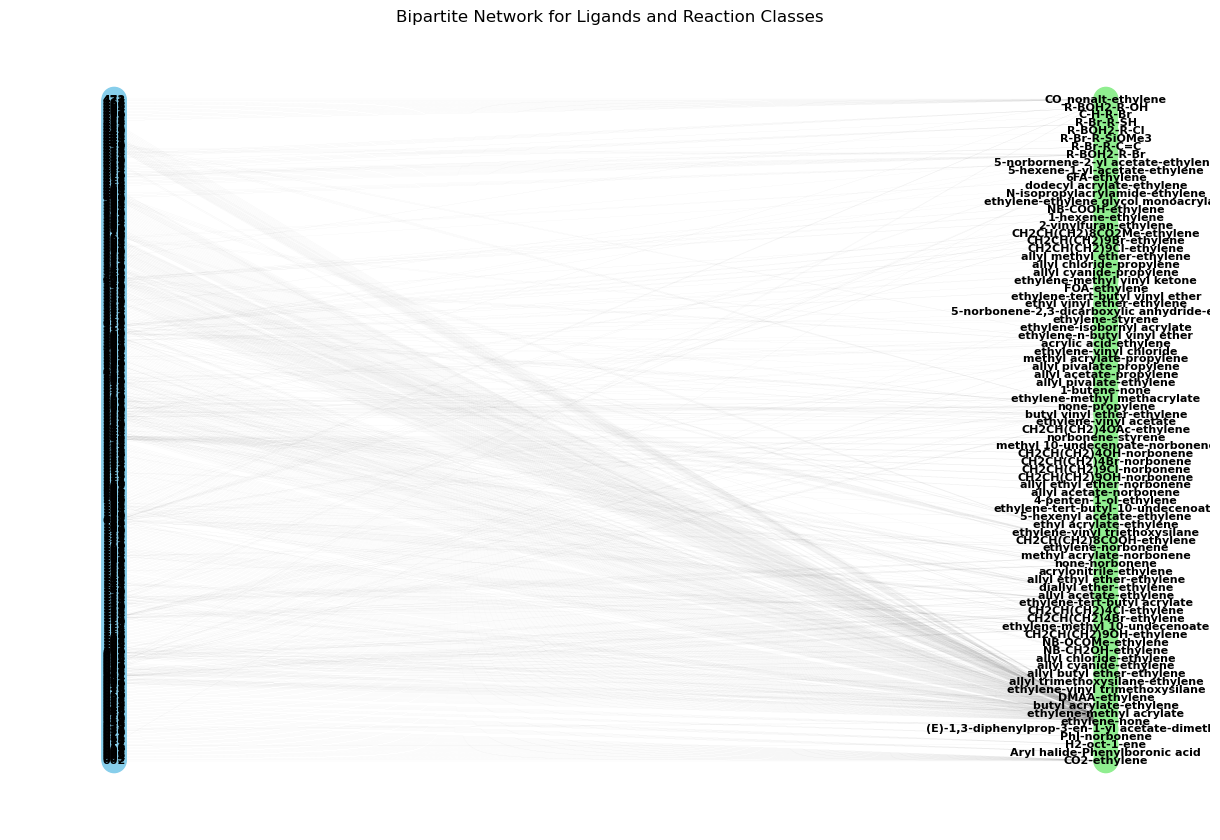

In [67]:
# Create bipartite network for visualization
# Set columns from pandas

lig_rxn_bipartite_df = lig_rxn_df[['lig_id','reaction_class']]

# Obtain unique list of ligand ids and reaction classes
d_nodes = lig_rxn_bipartite_df['lig_id'].unique()
t_nodes = lig_rxn_bipartite_df['reaction_class'].unique()

# Create a bipartite graph
exp_bipartite = nx.Graph()

# Add nodes from the first set (column1)
exp_bipartite.add_nodes_from(d_nodes, bipartite=0)

# Add nodes from the second set (column2)
exp_bipartite.add_nodes_from(t_nodes, bipartite=1)

# Add edges based on the DataFrame
edges = list(lig_rxn_bipartite_df.itertuples(index=False, name=None))
exp_bipartite.add_edges_from(edges)

# # Define edges connecting nodes from different sets
# edges = [(node1, node2) for node1 in d_nodes for node2 in t_nodes]
# # edges = [('A', 1), ('B', 2), ('C', 3)]
# exp_bipartite.add_edges_from(edges)

# Determine the number of nodes in each partite set
num_d_nodes, num_t_nodes = len(d_nodes), len(t_nodes)

print('Length of ligand nodes: ', num_d_nodes)
print('Length of reaction class nodes: ', num_t_nodes)

# Get total possible set of edges 
possible_edges = list(itertools.product(d_nodes, t_nodes))
# Print the total number of possible edges
print(f"Total number of possible edges: {len(possible_edges)}")

# Determine number of existing edges, missing edges
num_existing_edges = exp_bipartite.number_of_edges()
num_possible_edges = num_d_nodes*num_t_nodes
print('num_possible_edges', num_possible_edges)
# Number of missing edges
num_missing_edges = num_possible_edges - num_existing_edges

print('Number of existing edges:', num_existing_edges)
print('Number of possible edges:', num_possible_edges)
print('Number of missing edges:', num_missing_edges)

# Plot the bipartite graph
font_size = 8
edge_width = 0.01
pos = nx.bipartite_layout(exp_bipartite, nodes=d_nodes)

#Spring layout
# pos = nx.spring_layout(G


# Draw nodes and edges
plt.figure(figsize=(12, 8))

# Define colors for the nodes
node_colors = ['skyblue' if node in d_nodes else 'lightgreen' for node in exp_bipartite.nodes()]

nx.draw(exp_bipartite, pos, with_labels=True, font_weight='bold', node_color=node_colors,font_size=font_size,width=edge_width)

plt.title("Bipartite Network for Ligands and Reaction Classes")
plt.savefig('Bipartite network original dataset.png')

plt.show()



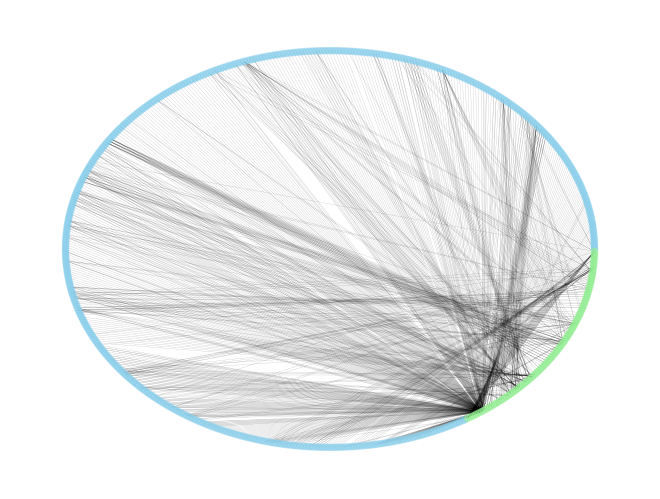

In [68]:
# Bipartite network visualized in a ciruclar form
nx.draw(exp_bipartite, pos=nx.circular_layout(exp_bipartite), alpha=0.5, width=0.1, node_color=node_colors, node_size=20)

Fold 1:
  Training set size: 708
  Test set size: 178
  Test set : [('007', 'CO2-ethylene'), ('013', 'CO2-ethylene'), ('031', 'ethylene-none'), ('032', 'ethylene-none'), ('044', 'CO2-ethylene'), ('018', 'Aryl halide-Phenylboronic acid'), ('019', 'Aryl halide-Phenylboronic acid'), ('021', 'Aryl halide-Phenylboronic acid'), ('048', 'H2-oct-1-ene'), ('057', '(E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate'), ('074', 'ethylene-none'), ('079', 'ethylene-none'), ('082', 'ethylene-none'), ('082', 'butyl acrylate-ethylene'), ('082', 'DMAA-ethylene'), ('083', 'ethylene-none'), ('083', 'DMAA-ethylene'), ('084', 'ethylene-methyl acrylate'), ('041', 'allyl trimethoxysilane-ethylene'), ('041', 'allyl butyl ether-ethylene'), ('041', 'allyl cyanide-ethylene'), ('041', 'CH2CH(CH2)9OH-ethylene'), ('041', 'CH2CH(CH2)4Br-ethylene'), ('085', 'ethylene-none'), ('087', 'CH2CH(CH2)4Cl-ethylene'), ('087', 'ethylene-methyl 10-undecenoate'), ('090', 'ethylene-methyl acrylate'), ('090', 'acrylic acid-eth

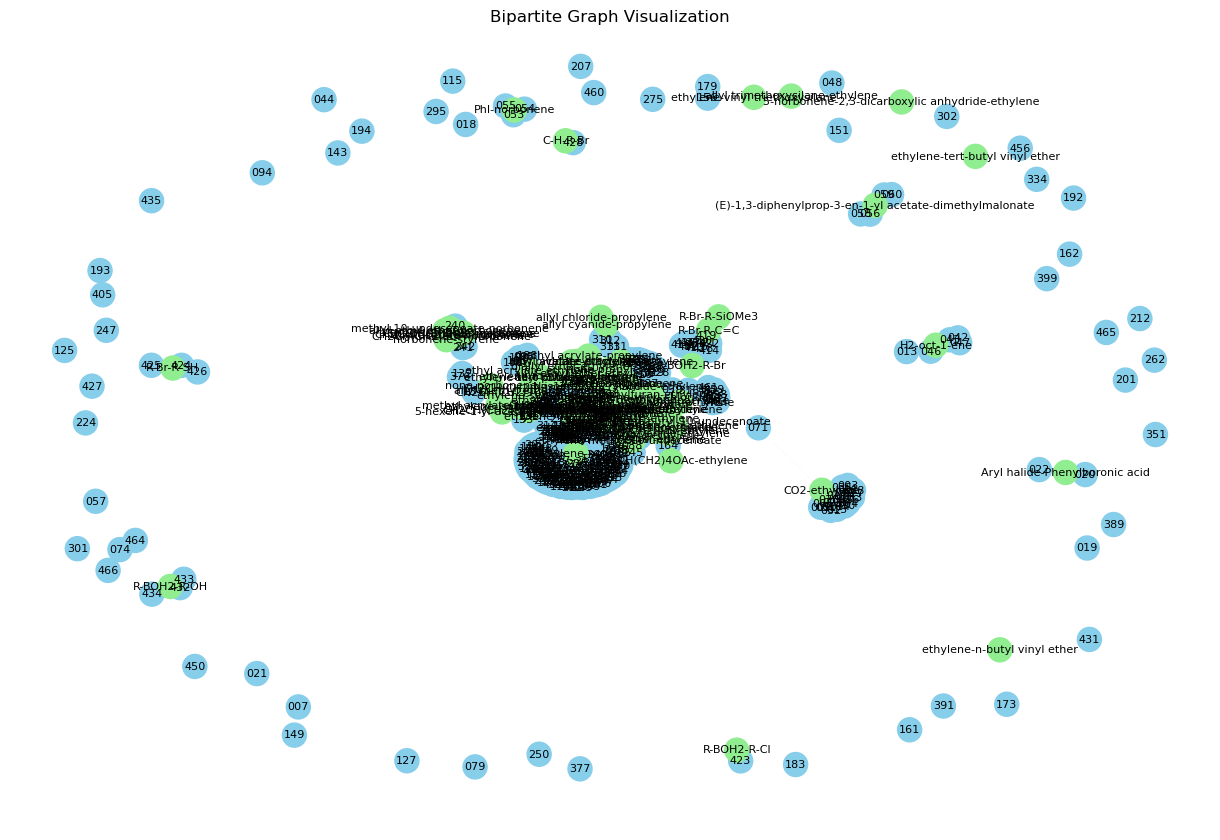

In [69]:
## Apply crossfold to create 5 training graphs
# Define 5-fold cross-validation
n_fold = 5
kf = KFold(n_splits=n_fold, shuffle=True, random_state=42)


edge_list = list(exp_bipartite.edges()) 

# Split the edges into 5 folds
folds = list(kf.split(edge_list))

# Create 5-fold cross-validation sets
cv_sets = []
for train_index, test_index in folds:
    train_edges = [edge_list[i] for i in train_index]
    test_edges = [edge_list[i] for i in test_index]
    cv_sets.append((train_edges, test_edges))

# Create a list to store the new graphs
bipartite_train_list = []
test_set_list = []
# Create a dictionary to store the test-edges for each graph 
dict_test_edges = {}

# Verify the cross-validation sets
for i, (train_edges, test_edges) in enumerate(cv_sets):
    print(f"Fold {i+1}:")
    print(f"  Training set size: {len(train_edges)}")
    print(f"  Test set size: {len(test_edges)}")
    print(f"  Test set : {test_edges}")
    dict_test_edges[f'test_edge_{i}'] = test_edges
    test_set_list.append(test_edges)

# Create new graphs for cross validation by removing test edges for each fold
for i, (train_edges, test_edges) in enumerate(cv_sets):
    bipartite_train = exp_bipartite.copy()
    bipartite_train.remove_edges_from(test_edges)
    bipartite_train_list.append(bipartite_train)

    # Print the sizes of the training and test sets
    print(f"Fold {i+1}:")
    print(f"  Training set size: {len(train_edges)}")
    print(f"  Test set size: {len(test_edges)}")

# Verify the new graphs
for i, bipartite_train in enumerate(bipartite_train_list):
    print(f"bipartite_train_{i+1} number of edges: {len(bipartite_train.edges())}")

#Visualize one of the training set graphs
visualize_bipartite_graph(bipartite_train_list[0], d_nodes, t_nodes)

# check_test_set(203, 'ethylene-none',dict_test_edges['test_edge_0'])

# Dictionary to store DataFrames for each graph in each cross validation fold
df_dict_dt = {}
df_dict_cluster_dt = {}
df_dict_merged_dt ={}

In [70]:
# Determine number of existing edges, missing edges
num_existing_edges = exp_bipartite.number_of_edges()
num_possible_edges = num_d_nodes*num_t_nodes
# Number of missing edges
num_missing_edges = num_possible_edges - num_existing_edges

In [103]:
# Identify which cluster dictionary is used to create ligand clusters
clusters = updated_cluster_dict_vbur_descriptor      # USE NBO/VBUR/ALL CLUSTER
# Iterate each graph within training set

# two list: one for bipartite graph_train, one for test_set list
for idx, (G,test_edges) in enumerate(zip(bipartite_train_list,test_set_list)):
# for G in B_train_list:
    # Get the pairs that have edges in training set graph
    edges_set = set(G.edges())

    print("Number of edges in this graph for training set: ", len(edges_set))
    # print("Number of all possible edges in this graph for training set: ", len(set(possible_edges)))
    # Find pairs with no edges between them
    training_no_edge_pairs = set(possible_edges) - edges_set
    training_no_edge_pairs = list(training_no_edge_pairs)

    # Ensure that the missing edges in each training set is equal to the sum of both the number of missing edges in the original graph and the additional ones from the test set
    assert len(training_no_edge_pairs) == num_missing_edges + len(test_edges)
    
    data = []
    # Calculate link prediction measures (CN, JC, PA) between for each pair of nodes without edges
    for d_node, t_node in training_no_edge_pairs:
        # print('d_node: ', d_node, ' t_node: ', t_node)
        num_common_neighbor, jaccard_coefficient = common_neighbor_jaccard_coef(G, d_node, t_node)
        preferential_d_t = preferential_attachment(G, d_node,t_node)
        data.append({
            'd_node': d_node,
            't_node': t_node,
            'common_neighbor': num_common_neighbor,
            'jaccard_coefficient': jaccard_coefficient,
            'preferential_attachment' : preferential_d_t
        })
    
    # Create the DataFrame of link prediction algorithm containing each d t pair that has missing edges, store into dctionary of dataframes
    df_neighbor = pd.DataFrame(data)
    df_dict_dt[f'graph_{idx}'] = df_neighbor
    print('Number of rows in node dataframe: ', df_dict_dt[f'graph_{idx}'].shape[0])

    # Create a new graph connecting t_nodes to clusters to form ligand cluster - reaction class links
    H = nx.Graph()
    H_zero = nx.Graph() #Add a H_zero graph to store data for links where weight = 0 
    # Add t nodes to the new graph
    H.add_nodes_from(t_nodes, bipartite=1)
    H_zero.add_nodes_from(t_nodes, bipartite=1)
    # Add cluster nodes to the new graph
    H.add_nodes_from(clusters.keys(), bipartite=0)
    H_zero.add_nodes_from(clusters.keys(), bipartite=0)

    print('Number of clusters: ', len(clusters))
    # Calculate the weights for links between clusters and t_nodes
    # Initialize a dictionary to store weights for cluster-t_node links
    cluster_t_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}
    
    # Create list for links with zero weight
    cluster_t_zero_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}    
    
    # Iterate over the original edges and update the weights for the new graph
    for d, t in G.edges():
        for cluster, d_list in clusters.items():  #extract cluster name and ligand node list within cluster
            if d in d_list:      
                cluster_t_weights[cluster][t] += 1
    # Add weighted edges to the new graph
    edge_added_count = 0
    for cluster, t_weights in cluster_t_weights.items():
        for t, w in t_weights.items():
            if w > 0:  # Only add edges with non-zero weight
                H.add_edge(cluster, t, weight=w)    #Missing some t, cluster combinations since there is no link.
                edge_added_count = edge_added_count + 1
            elif w == 0:
                H_zero.add_edge(cluster, t, weight=w)
                edge_added_count = edge_added_count + 1

    print('Edge added Count: ', edge_added_count)
    # Print the new graph edges with weights
    print("Edges in the new graph with weights:")
    
    for (u, v, wt) in H.edges(data='weight'):
        print(f"({u}, {v}, {wt})")
        
    cluster_edge_weights_list = list(H.edges(data='weight'))  # list of weights for c-t edges
    cluster_edge_zero_weights_list = list(H_zero.edges(data='weight')) # list of missing links for c-t combinations

    #Make sure number of cluster x number of t nodes equal to the number of all possible edges between cluster and t nodes
    assert len(clusters) * num_t_nodes == len(cluster_edge_weights_list) + len(cluster_edge_zero_weights_list)
    
    print(len(cluster_edge_weights_list)) #180 of c - t connection with weight > 0
    print(len(cluster_edge_zero_weights_list)) #210 of c - t connection with weight = 0
    
    # Create a list to store the data
    data_cluster = []

    count = 0
    # Iterate through the clusters and their connections to t_nodes, caluclate link prediction measures 
    for t, c, weight in cluster_edge_weights_list:
        for d in clusters[c]:
            count = count + 1
            degree_d_cluster = H.degree(c)
            degree_t = H.degree(t)
            data_cluster.append((d, 
                                 t, 
                                 weight, 
                                 len(cluster),
                                 weight/len(cluster), #Jaccard coefficient
                                 degree_d_cluster,
                                 degree_t,
                                 degree_d_cluster*degree_t))   #Preferential attachment
    print("Count: ", count)
    # Add the t_node cluster pair with no weights in to the dataframe as well, so we can get all 105 combinations of d and t
    for t, c, weight in cluster_edge_zero_weights_list:
        for d in clusters[c]:
            count = count + 1
            degree_d_cluster = H.degree(c)
            degree_t = H.degree(t)
            data_cluster.append((d, 
                                 t, 
                                 weight, 
                                 len(cluster),
                                 weight/len(cluster),
                                 degree_d_cluster,
                                 degree_t,
                                 degree_d_cluster*degree_t))
    print("Count2: ", count)
    # If t, cluster has no link, then we still need to record the d and t involved, where weight = 0, number of d in cluster is based on c
    # degree of cluster is equal to cluster, # jaccard coefficient is 0, degree_t is based on t preferential_attachment is calculated properly
    
    # Create the dataframe for cluster-t 
    cluster_df = pd.DataFrame(data_cluster, columns=['d_node', 
                                                     't_node', 
                                                     'common_neighbor_cluster',
                                                     'number of d in cluster',
                                                     'jaccard_coefficient_cluster',
                                                     'degree_d_cluster',
                                                     'degree_t',
                                                     'preferential_attachment_cluster'])
    
    print('Number of rows in cluster dataframe: ', cluster_df.shape[0])  #should have 105?

    # Make sure that the number of rows for the cluster dataframe is equal to the total possible combinations of all node connections
    assert cluster_df.shape[0] == len(set(possible_edges)), f"Assertion failed: cluster_df.shape[0] = {cluster_df.shape[0]}, len(set(possible_edges)) = {len(set(possible_edges))}"

    # Create a DataFrame from training_no_edge_pairs
    training_no_edge_pairs_df = pd.DataFrame(training_no_edge_pairs, columns=['d_node', 't_node'])
    print('Number of rows in no edge pair dataframe: ', training_no_edge_pairs_df.shape[0])
    
    # Merge the cluster_df with training_no_edge_pairs_df on d_node and t_node
    filtered_cluster_df = pd.merge(cluster_df, training_no_edge_pairs_df, on=['d_node', 't_node'])
    
    # Store dataframe into a dictionary of dataframes
    df_dict_cluster_dt[f'graph_{idx}'] = filtered_cluster_df

    df_dict_merged_dt[f'graph_{idx}'] = pd.merge(df_dict_dt[f'graph_{idx}'], df_dict_cluster_dt[f'graph_{idx}'], on=['d_node', 't_node'], how='inner')
    # print('Number of rows in merged dataframe: ', df_dict_merged_dt[f'graph_{idx}'].shape[0])

    # Make sure that the number of rows after merging is equal to the number of missing pairs from the training graph 
    assert df_dict_merged_dt[f'graph_{idx}'].shape[0] == len(training_no_edge_pairs)

# Check graph_0 within both dictionary
# print('Dataframe_neighbors: ',df_dict_dt['graph_0'])
# print('Dataframe_clusters: ',df_dict_cluster_dt['graph_0'])  
# print('Merged dataframe: ',df_dict_merged_dt['graph_0']) 
column_list = df_dict_merged_dt['graph_0'].columns.tolist() 
print(column_list)

Number of edges in this graph for training set:  708
Number of rows in node dataframe:  36437
Number of clusters:  5
Edge added Count:  425
Edges in the new graph with weights:
(CO2-ethylene, c1, 12)
(CO2-ethylene, c2, 1)
(CO2-ethylene, c3, 8)
(CO2-ethylene, c4, 2)
(CO2-ethylene, c5, 1)
(Aryl halide-Phenylboronic acid, c3, 1)
(Aryl halide-Phenylboronic acid, c5, 1)
(H2-oct-1-ene, c1, 1)
(H2-oct-1-ene, c3, 3)
(H2-oct-1-ene, c5, 1)
(PhI-norbonene, c1, 1)
(PhI-norbonene, c3, 1)
(PhI-norbonene, c5, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c3, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c4, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c5, 2)
(ethylene-none, c1, 44)
(ethylene-none, c2, 74)
(ethylene-none, c3, 40)
(ethylene-none, c4, 26)
(ethylene-none, c5, 64)
(ethylene-methyl acrylate, c1, 27)
(ethylene-methyl acrylate, c2, 7)
(ethylene-methyl acrylate, c3, 11)
(ethylene-methyl acrylate, c4, 10)
(ethylene-methyl acrylate, c5, 35)
(butyl a

In [104]:
# Evaluate Precision & AUPR for each cross validation by using the test set established earlier:
# Iterate through each dataframe. For each dataframe, obtain rows with test set node pairs only (which should all be 1) normalize prediction scores, 
# Generate Precision & AUPR for that dataframe for each link prediction algorithm
# Then obtain average AUC and AUPR for all dataframe to reach link prediction algorithm 
# References for understanding link prediction evaluation metrics:
# Simone Daminelli et al 2015 New J. Phys. 17 113037 Main journal used for adopting precision & aupr over auc
# Yang, Y., Lichtenwalter, R.N. & Chawla, N.V. Evaluating link prediction methods. Knowl Inf Syst 45, 751–782 (2015). States that ROC is deceptive.
    
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score #Not accurage for checking area under AUC. https://datascience.stackexchange.com/questions/52130/about-sklearn-metrics-average-precision-score-documentation
from sklearn.metrics import precision_recall_curve, auc

score_column = ['common_neighbor', 
                'jaccard_coefficient', 
                'preferential_attachment', 
                'common_neighbor_cluster', 
                'jaccard_coefficient_cluster', 
                'preferential_attachment_cluster']

# Initialize DataFrames to store AUC and AUPR scores
auc_df = pd.DataFrame(index=score_column)
aupr_df = pd.DataFrame(index=score_column)
all_results = []

for idx in range(n_fold):
    df_merge = df_dict_merged_dt[f'graph_{idx}'] # Get all missing edges from the training set graph
    # Normalize each column
    for column in score_column:
        min_value = df_merge[column].min()
        max_value = df_merge[column].max()
        df_merge[column] = (df_merge[column] - min_value) / (max_value - min_value)

    #print('df_merge_normalized: ', df_merge)
    test_edges_set = set(dict_test_edges[f'test_edge_{idx}']) # Used to identify the test_edges

    l = len(test_edges_set)    # Set l as number of test edges
    
    print('List of test edges:', test_edges_set)
    # Create a new column in df_merge called 'actual outcome'
    # For d node and t nodes that are within the list_test_edges, put 1 in the acutal outcome
    # For the rest of the nodes, put 0
    df_merge['actual outcome'] = df_merge.apply(lambda row: 1 if (row['d_node'], row['t_node']) in test_edges_set else 0, axis=1)
    print(df_merge)


    # Iterate through each prediction algorithm and calculate the metrics
    results = []
    for score_type in score_column:
        precision_at_L, aupr = calculate_metric(df_merge, score_type, l)
        results.append({'Score_type': score_type, 'precision_at_L': precision_at_L, 'aupr': aupr})
        
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Append to all results
    all_results.append(results_df)
    
    # Display the results
    print(results_df)


# Concatenate all results DataFrames into a single DataFrame
concatenated_results = pd.concat(all_results)

# Group by algorithm and calculate the mean of precision_at_L and aupr
average_results = concatenated_results.groupby('Score_type').mean().reset_index()
    # Iterate through each prediction algorithm, by creating a dataframe where we have the d_node, t_node, prediction algorithm, and actual outcome
    # sort rows based on the normalized score under the prediction algorithm
    # Obtain precision value by analyzing how many 1s are there in the top L rows out of L rows
    # Obtain AUPR with both column
# Display the average results
print('Average results: ', average_results)


List of test edges: {('041', 'allyl butyl ether-ethylene'), ('350', 'ethylene-methyl acrylate'), ('260', 'allyl acetate-propylene'), ('427', 'R-Br-R-SH'), ('019', 'Aryl halide-Phenylboronic acid'), ('187', 'ethylene-none'), ('134', 'ethylene-none'), ('359', 'ethylene-methyl acrylate'), ('248', 'allyl chloride-ethylene'), ('099', 'allyl acetate-ethylene'), ('133', 'ethylene-methyl acrylate'), ('194', 'ethylene-tert-butyl acrylate'), ('360', 'ethylene-methyl acrylate'), ('440', 'ethylene-none'), ('132', 'ethylene-none'), ('240', 'norbonene-styrene'), ('090', 'acrylic acid-ethylene'), ('272', 'ethylene-methyl acrylate'), ('179', 'ethylene-none'), ('244', 'ethylene-none'), ('255', 'butyl vinyl ether-ethylene'), ('021', 'Aryl halide-Phenylboronic acid'), ('032', 'ethylene-none'), ('082', 'DMAA-ethylene'), ('242', 'allyl ethyl ether-norbonene'), ('038', 'ethylene-vinyl chloride'), ('308', 'ethylene-norbonene'), ('409', 'NB-COOH-ethylene'), ('124', 'ethylene-none'), ('305', 'ethylene-norbonen

In [105]:
average_results

Score_type  precision_at_L      aupr
0                  common_neighbor        0.157995  0.111577
1          common_neighbor_cluster        0.330712  0.250343
2              jaccard_coefficient        0.005643  0.044832
3      jaccard_coefficient_cluster        0.330712  0.250343
4          preferential_attachment        0.189602  0.099423
5  preferential_attachment_cluster        0.030489  0.083618

## After assesssing which score_type is better, apply it to predict candidates
## Make function to choose a candidate, and then score different reaction classes from the ligand
## Make function to chose a reaction class, and then rank different ligand for that reaction class

In [106]:
# Identify which cluster dictionary is used to create ligand clusters
clusters = updated_cluster_dict_vbur_descriptor 

edge_set = set(exp_bipartite.edges()) 

num_no_edge_pairs = list(set(possible_edges) - edges_set)

for d_node, t_node in num_no_edge_pairs:
    # print('d_node: ', d_node, ' t_node: ', t_node)
    num_common_neighbor, jaccard_coefficient = common_neighbor_jaccard_coef(exp_bipartite, d_node, t_node)
    preferential_d_t = preferential_attachment(exp_bipartite, d_node,t_node)
    data.append({
        'd_node': d_node,
        't_node': t_node,
        'common_neighbor': num_common_neighbor,
        'jaccard_coefficient': jaccard_coefficient,
        'preferential_attachment' : preferential_d_t
    })

# Create the DataFrame of link prediction algorithm containing each d t pair that has missing edges, store into dctionary of dataframes
df_all_neighbor = pd.DataFrame(data)
df_all_neighbor = df_all_neighbor.drop_duplicates(subset=['d_node', 't_node'])


# Create a new graph connecting t_nodes to clusters to form ligand cluster - reaction class links
H = nx.Graph()
H_zero = nx.Graph() #Add a H_zero graph to store data for links where weight = 0 
# Add t nodes to the new graph
H.add_nodes_from(t_nodes, bipartite=1)
H_zero.add_nodes_from(t_nodes, bipartite=1)
# Add cluster nodes to the new graph
H.add_nodes_from(clusters.keys(), bipartite=0)
H_zero.add_nodes_from(clusters.keys(), bipartite=0)

print('Number of clusters: ', len(clusters))
# Calculate the weights for links between clusters and t_nodes
# Initialize a dictionary to store weights for cluster-t_node links
cluster_t_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}

# Create list for links with zero weight
cluster_t_zero_weights = {cluster: {t: 0 for t in t_nodes} for cluster in clusters}    

# Iterate over the original edges and update the weights for the new graph
for d, t in exp_bipartite.edges():
    for cluster, d_list in clusters.items():  #extract cluster name and ligand node list within cluster
        if d in d_list:      
            cluster_t_weights[cluster][t] += 1
# Add weighted edges to the new graph
edge_added_count = 0
for cluster, t_weights in cluster_t_weights.items():
    for t, w in t_weights.items():
        if w > 0:  # Only add edges with non-zero weight
            H.add_edge(cluster, t, weight=w)    #Missing some t, cluster combinations since there is no link.
            edge_added_count = edge_added_count + 1
        elif w == 0:
            H_zero.add_edge(cluster, t, weight=w)
            edge_added_count = edge_added_count + 1

print('Edge added Count: ', edge_added_count)
# Print the new graph edges with weights
print("Edges in the new graph with weights:")

for (u, v, wt) in H.edges(data='weight'):
    print(f"({u}, {v}, {wt})")
    
cluster_edge_weights_list = list(H.edges(data='weight'))  # list of weights for c-t edges
cluster_edge_zero_weights_list = list(H_zero.edges(data='weight')) # list of missing links for c-t combinations

#Make sure number of cluster x number of t nodes equal to the number of all possible edges between cluster and t nodes
assert len(clusters) * num_t_nodes == len(cluster_edge_weights_list) + len(cluster_edge_zero_weights_list)

print('Number of t nodes:', num_t_nodes)
print('Number of d nodes:', num_d_nodes)

# Create a list to store the data
data_cluster = []

count = 0
# Iterate through the clusters and their connections to t_nodes, caluclate link prediction measures 
for t, c, weight in cluster_edge_weights_list:
    for d in clusters[c]:
        count = count + 1
        degree_d_cluster = H.degree(c)
        degree_t = H.degree(t)
        data_cluster.append((d, 
                             t, 
                             weight, 
                             len(cluster),
                             weight/len(cluster), #Jaccard coefficient
                             degree_d_cluster,
                             degree_t,
                             degree_d_cluster*degree_t))   #Preferential attachment
print("Count: ", count)
# Add the t_node cluster pair with no weights in to the dataframe as well, so we can get all 105 combinations of d and t
for t, c, weight in cluster_edge_zero_weights_list:
    for d in clusters[c]:
        count = count + 1
        degree_d_cluster = H.degree(c)
        degree_t = H.degree(t)
        data_cluster.append((d, 
                             t, 
                             weight, 
                             len(cluster),
                             weight/len(cluster),
                             degree_d_cluster,
                             degree_t,
                             degree_d_cluster*degree_t))
print("Count2: ", count)
# If t, cluster has no link, then we still need to record the d and t involved, where weight = 0, number of d in cluster is based on c
# degree of cluster is equal to cluster, # jaccard coefficient is 0, degree_t is based on t preferential_attachment is calculated properly

# Create the dataframe for cluster-t 
cluster_df = pd.DataFrame(data_cluster, columns=['d_node', 
                                                 't_node', 
                                                 'common_neighbor_cluster',
                                                 'number of d in cluster',
                                                 'jaccard_coefficient_cluster',
                                                 'degree_d_cluster',
                                                 'degree_t',
                                                 'preferential_attachment_cluster'])

print('Number of rows in cluster dataframe: ', cluster_df.shape[0])  

# Make sure that the number of rows for the cluster dataframe is equal to the total possible combinations of all node connections
assert cluster_df.shape[0] == len(set(possible_edges)), f"Assertion failed: cluster_df.shape[0] = {cluster_df.shape[0]}, len(set(possible_edges)) = {len(set(possible_edges))}"

Number of clusters:  5
Edge added Count:  425
Edges in the new graph with weights:
(CO2-ethylene, c1, 14)
(CO2-ethylene, c2, 1)
(CO2-ethylene, c3, 9)
(CO2-ethylene, c4, 2)
(CO2-ethylene, c5, 1)
(Aryl halide-Phenylboronic acid, c3, 4)
(Aryl halide-Phenylboronic acid, c5, 1)
(H2-oct-1-ene, c1, 2)
(H2-oct-1-ene, c3, 3)
(H2-oct-1-ene, c5, 1)
(PhI-norbonene, c1, 1)
(PhI-norbonene, c3, 1)
(PhI-norbonene, c5, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c3, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c4, 1)
((E)-1,3-diphenylprop-3-en-1-yl acetate-dimethylmalonate, c5, 3)
(ethylene-none, c1, 53)
(ethylene-none, c2, 92)
(ethylene-none, c3, 52)
(ethylene-none, c4, 34)
(ethylene-none, c5, 80)
(ethylene-methyl acrylate, c1, 28)
(ethylene-methyl acrylate, c2, 12)
(ethylene-methyl acrylate, c3, 15)
(ethylene-methyl acrylate, c4, 12)
(ethylene-methyl acrylate, c5, 43)
(butyl acrylate-ethylene, c1, 6)
(butyl acrylate-ethylene, c2, 1)
(butyl acrylate-ethylene, c3, 1)
(b

In [107]:
df_all_neighbor 

d_node                      t_node  common_neighbor  \
0        279   dodecyl acrylate-ethylene                0   
1        299                 R-BOH2-R-Cl                0   
2        175     butyl acrylate-ethylene               10   
3        300            ethylene-styrene                0   
4        292  ethyl vinyl ether-ethylene                0   
...      ...                         ...              ...   
36431    112          CO_nonalt-ethylene                6   
36432    388    ethylene-methyl acrylate                0   
36433    231    ethylene-methyl acrylate                0   
36434    386     ethyl acrylate-ethylene                0   
36435    207      4-penten-1-ol-ethylene                2   

       jaccard_coefficient  preferential_attachment  
0                 0.000000                        0  
1                 0.000000                        0  
2                 0.833333                       11  
3                 0.000000                        0  
4                 0.000000                        0  
...                    ...                      ...  
36431             0.300000                       19  
36432             0.000000                        0  
36433             0.000000                        0  
36434             0.000000                        0  
36435             1.000000                        1  

[36436 rows x 5 columns]

In [108]:
# Merge the two dataframes on d_node and t_node to obtain all link prediction measures for missing links in the experimental bipartite network
merged_df = pd.merge(df_all_neighbor, cluster_df, on=['d_node', 't_node'])

# Display the merged dataframe
merged_df

d_node                      t_node  common_neighbor  \
0        279   dodecyl acrylate-ethylene                0   
1        299                 R-BOH2-R-Cl                0   
2        175     butyl acrylate-ethylene               10   
3        300            ethylene-styrene                0   
4        292  ethyl vinyl ether-ethylene                0   
...      ...                         ...              ...   
36431    112          CO_nonalt-ethylene                6   
36432    388    ethylene-methyl acrylate                0   
36433    231    ethylene-methyl acrylate                0   
36434    386     ethyl acrylate-ethylene                0   
36435    207      4-penten-1-ol-ethylene                2   

       jaccard_coefficient  preferential_attachment  common_neighbor_cluster  \
0                 0.000000                        0                        0   
1                 0.000000                        0                        0   
2                 0.833333                       11                        1   
3                 0.000000                        0                        1   
4                 0.000000                        0                        0   
...                    ...                      ...                      ...   
36431             0.300000                       19                        2   
36432             0.000000                        0                       15   
36433             0.000000                        0                       12   
36434             0.000000                        0                        0   
36435             1.000000                        1                        1   

       number of d in cluster  jaccard_coefficient_cluster  degree_d_cluster  \
0                           2                          0.0                44   
1                           2                          0.0                53   
2                           2                          0.5                44   
3                           2                          0.5                44   
4                           2                          0.0                51   
...                       ...                          ...               ...   
36431                       2                          1.0                44   
36432                       2                          7.5                44   
36433                       2                          6.0                53   
36434                       2                          0.0                44   
36435                       2                          0.5                53   

       degree_t  preferential_attachment_cluster  
0             1                               44  
1             1                               53  
2             5                              220  
3             2                               88  
4             2                              102  
...         ...                              ...  
36431         5                              220  
36432         5                              220  
36433         5                              265  
36434         1                               44  
36435         1                               53  

[36436 rows x 11 columns]

In [109]:
# Filter rows where the 't_node' column contains the string 'CO2-ethylene'

reaction_name = 'CO_nonalt-ethylene'

filtered_df = merged_df[merged_df['t_node'].str.contains(reaction_name, na=False)]

# Display the filtered DataFrame
display(filtered_df)

# Save the filtered DataFrame to a CSV file
filtered_df.to_csv('filtered_'+ reaction_name + '.csv', index=False)

d_node              t_node  common_neighbor  jaccard_coefficient  \
77       302  CO_nonalt-ethylene                6             0.300000   
227      155  CO_nonalt-ethylene                6             0.300000   
268      384  CO_nonalt-ethylene                6             0.300000   
447      320  CO_nonalt-ethylene                2             0.100000   
500      033  CO_nonalt-ethylene                0             0.000000   
...      ...                 ...              ...                  ...   
36035    171  CO_nonalt-ethylene                6             0.300000   
36089    043  CO_nonalt-ethylene                0             0.000000   
36312    013  CO_nonalt-ethylene                0             0.000000   
36398    258  CO_nonalt-ethylene                9             0.333333   
36431    112  CO_nonalt-ethylene                6             0.300000   

       preferential_attachment  common_neighbor_cluster  \
77                          19                        2   
227                         19                        5   
268                         19                        2   
447                         19                        2   
500                         19                        6   
...                        ...                      ...   
36035                       19                        5   
36089                       19                        2   
36312                       38                        6   
36398                      152                        5   
36431                       19                        2   

       number of d in cluster  jaccard_coefficient_cluster  degree_d_cluster  \
77                          2                          1.0                44   
227                         2                          2.5                27   
268                         2                          1.0                44   
447                         2                          1.0                44   
500                         2                          3.0                51   
...                       ...                          ...               ...   
36035                       2                          2.5                53   
36089                       2                          1.0                44   
36312                       2                          3.0                51   
36398                       2                          2.5                27   
36431                       2                          1.0                44   

       degree_t  preferential_attachment_cluster  
77            5                              220  
227           5                              135  
268           5                              220  
447           5                              220  
500           5                              255  
...         ...                              ...  
36035         5                              265  
36089         5                              220  
36312         5                              255  
36398         5                              135  
36431         5                              220  

[418 rows x 11 columns]

In [110]:
# Define the function to get top 20 t_nodes with renamed columns
def get_top_20_t_nodes(df, d_node, measure):
    # Filter the DataFrame for the specified d_node
    filtered_df = df[df['d_node'] == d_node]
    
    # Sort the DataFrame by the specified measure in descending order
    sorted_df = filtered_df.sort_values(by=measure, ascending=False)
    
    # Select the top 20 t_nodes and rename columns
    top_20_t_nodes = sorted_df.head(100)[['t_node', measure]]
    top_20_t_nodes = top_20_t_nodes.rename(columns={'t_node': 'Reaction', measure: 'Confidence'})
    
    return top_20_t_nodes

# Define the function to get top 20 d_nodes with renamed columns
def get_top_20_d_nodes(df, t_node, measure):
    # Filter the DataFrame for the specified t_node
    filtered_df = df[df['t_node'] == t_node]
    
    # Sort the DataFrame by the specified measure in descending order
    sorted_df = filtered_df.sort_values(by=measure, ascending=False)
    
    # Select the top 20 d_nodes and rename columns
    top_20_d_nodes = sorted_df.head(40)[['d_node', measure]]
    top_20_d_nodes = top_20_d_nodes.rename(columns={'d_node': 'Ligand', measure: 'Confidence'})
    
    return top_20_d_nodes

# Example usage for d_node
d_node = '038'
measure = 'common_neighbor_cluster'
top_20_t_nodes = get_top_20_t_nodes(merged_df, d_node, measure)
print("Top 20 Reactions for Ligand {} based on Confidence:".format(d_node))
display(top_20_t_nodes)

# Example usage for t_node
t_node = 'CO_nonalt-ethylene'
measure = 'common_neighbor_cluster'
top_20_d_nodes = get_top_20_d_nodes(merged_df, t_node, measure)
print("Top 20 Ligands for Reaction {} based on Confidence:".format(t_node))
display(top_20_d_nodes)


Top 20 Reactions for Ligand 038 based on Confidence:


Reaction  Confidence
9913    ethylene-methyl 10-undecenoate           7
30239           allyl acetate-ethylene           6
25205           CH2CH(CH2)9OH-ethylene           3
28745          allyl chloride-ethylene           3
533          methyl acrylate-propylene           2
...                                ...         ...
8763    Aryl halide-Phenylboronic acid           0
24945      allyl methyl ether-ethylene           0
8311      ethylene-n-butyl vinyl ether           0
25296  allyl trimethoxysilane-ethylene           0
25865   ethylene-vinyl triethoxysilane           0

[70 rows x 2 columns]

Top 20 Ligands for Reaction CO_nonalt-ethylene based on Confidence:


Ligand  Confidence
6543     107           6
15588    233           6
6519     245           6
6483     016           6
15460    447           6
6185     027           6
15450    139           6
10507    446           6
26901    268           6
30888    292           6
25694    249           6
34131    291           6
5662     120           6
10884    430           6
5554     142           6
5382     081           6
18747    053           6
28195    449           6
26118    095           6
5054     029           6
24603    260           6
34118    143           6
6712     448           6
11544    243           6
15614    005           6
9230     140           6
34839    290           6
16455    234           6
27292    131           6
27468    242           6
8143     014           6
25536    195           6
34676    442           6
34870    324           6
25275    082           6
17104    273           6
31163    246           6
7705     080           6
9635     192           6
33646    271           6

In [111]:
# Why is CO-nonalternating ethylene so weird??
# Check cluster 
# Change cluster?

In [112]:
df

lig_id ligand_name                                             SMILES  \
0          1       n-n-1                                       CN(CCN(C)C)C   
1          1       n-n-1                                       CN(CCN(C)C)C   
2          2       p-p-1  P(CCP(C1=CC=CC=C1)C2=CC=CC=C2)(C3=CC=CC=C3)C4=...   
3          2       p-p-1  P(CCP(C1=CC=CC=C1)C2=CC=CC=C2)(C3=CC=CC=C3)C4=...   
4          3       p-p-2  P(CCCP(C1=CC=CC=C1)C2=CC=CC=C2)(C3=CC=CC=C3)C4...   
...      ...         ...                                                ...   
2054     471     p-o-168       [O-]C1=C(C(C)(C)C)C=CC=C1P(C2CCCCC2)C3CCCCC3   
2055     472     p-o-169  [O-]C1=C2C(C=CC=C2)=CC=C1P(C3=CC=CC=C3)C4=CC=C...   
2056     473     p-o-170      O=S(C1=CC=CC=C1P(C2=CC=CC=C2)C3CCCCC3)([O])=O   
2057     187      p-o-54         O=S(C1=CC=CC=C1P(C2CCCCC2)C3CCCCC3)([O])=O   
2058     251      p-o-66               O=S(C1=CC=CC=C1P(C(C)C)C(C)C)([O])=O   

     exp_id                                ref substrate_comb metal  \
0         1  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
1         2  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
2         3  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
3         4  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
4         5  ChemSusChem, 2011, 4, 1275 – 1279    CO2ethylene    Ni   
...     ...                                ...            ...   ...   
2054   2066        Science 374, 604–607 (2021)            NaN    Ni   
2055   2067        Science 374, 604–607 (2021)            NaN    Ni   
2056   2068  Eur. Polym. J. 2024, 210, 113007.            NaN    Pd   
2057   2069  Eur. Polym. J. 2024, 210, 113007.            NaN    Pd   
2058   2070  Eur. Polym. J. 2024, 210, 113007.            NaN    Pd   

     substrate_1 substrate_2  solvent  ...  additive  additive_equiv  \
0            CO2    ethylene      dcm  ...      ch3i              10   
1            CO2    ethylene      dcm  ...      ch3i             100   
2            CO2    ethylene      dcm  ...      ch3i              10   
3            CO2    ethylene      dcm  ...      ch3i             100   
4            CO2    ethylene      dcm  ...      ch3i              10   
...          ...         ...      ...  ...       ...             ...   
2054    ethylene   CO_nonalt  toluene  ...       NaN             NaN   
2055    ethylene   CO_nonalt  toluene  ...       NaN             NaN   
2056    ethylene   CO_nonalt      dcm  ...       NaN             NaN   
2057    ethylene   CO_nonalt      dcm  ...       NaN             NaN   
2058    ethylene   CO_nonalt      dcm  ...       NaN             NaN   

     substrate_ratio volume_ml  activity_kg_mol yield     mn  time_hr  \
0                NaN       4.0              NaN  21.0    NaN      3.0   
1                NaN       4.0              NaN  56.0    NaN      3.0   
2                NaN       4.0              NaN  14.0    NaN     48.0   
3                NaN       4.0              NaN  29.0    NaN     48.0   
4                NaN       4.0              NaN  18.0    NaN     24.0   
...              ...       ...              ...   ...    ...      ...   
2054             NaN     100.0              NaN   NaN  45000      2.0   
2055             NaN     100.0              NaN   NaN  90000      2.0   
2056             NaN      20.0             24.0   NaN   77.2      1.0   
2057             NaN      20.0             29.8   NaN  103.3      1.0   
2058             NaN      20.0             24.5   NaN   77.3      1.0   

      incorporatio_ratio  ton  
0                    NaN  NaN  
1                    NaN  NaN  
2                    NaN  NaN  
3                    NaN  NaN  
4                    NaN  NaN  
...                  ...  ...  
2054                 NaN  NaN  
2055                 NaN  NaN  
2056                12.2  NaN  
2057                17.5  NaN  
2058                12.1  NaN  

[2059 rows x 25 columns]

In [113]:
## Check if it shows result that already have link with reaction:
## Generate SMILES for pandas

# Ensure 'Ligand' in ligand_confidence_df and 'lig_id' in df are of the same type
# Convert both to strings just to be safe (optional, depending on your data)
top_20_d_nodes['Ligand'] = top_20_d_nodes['Ligand'].astype(int)
df['lig_id'] = df['lig_id'].astype(int)

top_20_d_nodes_smiles_df = pd.merge(top_20_d_nodes, df[['lig_id', 'SMILES', 'ligand_name']], left_on='Ligand', right_on='lig_id', how='left')
# Drop the 'lig_id' column after merging (optional)
top_20_d_nodes_smiles_df = top_20_d_nodes_smiles_df.drop(columns=['lig_id'])
top_20_d_nodes_smiles_df = top_20_d_nodes_smiles_df.drop_duplicates()

# Display the result
display(top_20_d_nodes_smiles_df)


Ligand  Confidence                                             SMILES  \
0       107           6  [O]C1=C(P(C2=CC=CC=C2)C3=CC=CC=C3)C=CC=C1C4=CC...   
3       233           6  COC(C=CC=C1OC)=C1C2=CC=CC=C2P(C3=CC=CC=C3)CC4=...   
8       245           6  O=P(N(C(C)C)C(C)C)(C1=CC=CC=C1)C2=CC=CC=C2P(C3...   
19       16           6  CC1=CC(C)=CC(C)=C1N(C2)C3=C(C=CC=C3)N2CP(C4CCC...   
20      447           6  O=C(N(C)P(C1=CC=CC=C1C2=C(OC)C=CC=C2OC)C3=CC=C...   
23       27           6                     CCCC[Pt](CC[Pt](CCCC)CCCC)CCCC   
24      139           6  O=[P](C1=C(OCCOC)C=CC=C1)C2=CC=CC=C2P(C3=C(OC)...   
39      446           6  O=C(N(CC1=CC=CC=C1)P(C2=CC=CC=C2C3=C(OC)C=CC=C...   
42      268           6  O=P(C(C)(C)C)(C(C)(C)C)C1=CC=CC=C1P(C2=CC=CC=C...   
44      292           6  O=P(N(C(C)C)C(C)C)(N(C(C)C)C(C)C)C1=CC=CC=C1P(...   
46      249           6  O=P(C(C)(C)C)(C(C)(C)C)C1=CC=CC2=CN(C3=C(CC4=C...   
47      291           6  O=P(N(CC)CC)(N(CC)CC)C1=CC=CC=C1P(C2=C(OC)C=CC...   
48      120           6  CC(C1=CC=CC(C(C)C)=C1/N=C/C2=CC=CC=C2P(C3=CC=C...   
51      430           6                 CCN(CCN(C1=CC=CC=C1)CC)C2=CC=CC=C2   
52      142           6    [H]/C(C1=NC(C)=CC=C1)=N\C2=C(C(C)C)C=CC=C2C(C)C   
58       81           6  [O-]C(C(C(C)(C)C)=CC=C1)=C1P(C2=CC=CC=C2)C3=C(...   
69       53           6  C1(P(C2=CC=CC=C2)C3=CC=CC=C3)=CC=CC=C1N4CN(C5=...   
70      449           6  O=C(N(C)P(C1=CC=CC=C1C2=C(OC)C=CC=C2OC)C3=CC=C...   
72       95           6  OC(C(C(C1=CC(C(C)(C)C)=CC(C(C)(C)C)=C1)=CC=C2)...   
77       29           6  [H][C@@]1([C@]2([H])[P@@](C(C)(C)C)CCC2)[P@@](...   
78      260           6  OC1=C(C2=C(C)C=C(C)C=C2C)C=CC3=C1N4C(C=C3)=CN(...   
84      143           6      C/C(C1=NC(C)=CC=C1)=N\C2=C(C(C)C)C=CC=C2C(C)C   
86      448           6  O=C(N(C)P(C1=CC=CC=C1C2=C(OC)C=CC=C2OC)C3=CC=C...   
88      243           6  O=P(N(C(C)C)C(C)C)(C1=CC=CC=C1)C2=CC=CC=C2P(C3...   
93        5           6  CC(C1=CC=CC(C(C)C)=C1N2CN3C(C4=NC=CC=C4)=CC=CC...   
95      140           6  C/C(C1=NC(C2=C(C)C=CC=C2C)=CC=C1)=N\C3=C(C(C)C...   
99      290           6  O=P(N(C)C)(N(C)C)C1=CC=CC=C1P(C2=C(OC)C=CC=C2)...   
105     234           6  COC(C=CC=C1OC)=C1C2=CC=CC=C2P(C3=CC=CC=C3)NC4=...   
106     131           6  [H]C(C=CC=C1)=C1P(C2=C([H])C=CC=C2)C3=CC=CC=C3...   
122     242           6  OC1=C(/N=C2N(C3=C(C(C4=CC=CC=C4)C5=CC=CC=C5)C=...   
135      14           6   CC1=CC(C)=CC(C)=C1N(C2)C=CN2CP(C3CCCCC3)C4CCCCC4   
143     195           6  [O]C1=C([Si](C)(C)C)C=CC=C1P(C2=C(OC)C=CC=C2OC...   
144     442           6  O=C(N(C)P(C1=CC=CC=C1C2=C(OC)C=CC=C2OC)C3=CC=C...   
154     324           6  CC(C=CC=C1C)=C1/N=C(C2=C3C(C=CC=C34)=CC=C2)/C4...   
155      82           6  [O-]C(C(C(C)(C)C)=CC=C1)=C1P(C2=CC=CC=C2)C3=C(...   
161     273           6  O=P(C1=CC=CC=C1)(C2=CC=CC=C2)C3=CC=CC=C3P(C4=C...   
162     246           6  O=S([N-]C1=CC=CC2=C1N3C(C=C2)=CN(C4=C(C(C)C)C=...   
167      80           6  [O-]C(C(C(C)(C)C)=CC=C1)=C1P(C2=CC=CC=C2)C3=CC...   
173     192           6  OC1=C(C2=C(F)C(F)=C(F)C(F)=C2F)C=CC=C1P(C3=C(O...   
174     271           6  O=P(C(C)C)(C(C)C)C1=CC=CC=C1P(C2=CC=CC=C2C(F)(...   

    ligand_name  
0        p-o-33  
3         p-n-9  
8        p-o-65  
19        p-c-3  
20      p-o-149  
23        p-p-6  
24       p-o-42  
39      p-o-148  
42       p-o-77  
44      p-o-104  
46        c-o-5  
47      p-o-103  
48        p-n-3  
51       n-n-99  
52       n-n-12  
58        p-o-7  
69       p-c-18  
70      p-o-151  
72       p-o-21  
77        p-p-8  
78       c-o-10  
84       n-n-13  
86      p-o-150  
88       p-o-63  
93        c-n-1  
95       n-n-10  
99      p-o-102  
105      p-n-10  
106       p-n-4  
122      n-o-79  
135       p-c-1  
143      p-o-62  
144     p-o-144  
154      n-n-37  
155       p-o-8  
161      p-o-82  
162       c-n-8  
167       p-o-6  
173      p-o-59  
174      p-o-80

In [114]:
# 55, 315, 390, 386, 263, 318, 291
# Stuff to fix: why is it recommending nodes that already have link with CO2-ethylene? SOmething is going wrong. 

In [115]:
# Changes: Add the ability to use SMILES from ligand database and draw it 

In [116]:
exp_bipartite

In [117]:
import networkx as nx

def get_neighbors_of_degree(graph, node, max_degree):
    """
    Get the neighbors of a given node up to a specified degree and the count of nodes at each degree.
    
    Parameters:
    - graph: networkx.Graph
    - node: the node to examine
    - max_degree: the maximum degree up to which neighbors should be returned
    
    Returns:
    - neighbors_by_degree: a dictionary where keys are degrees and values are sets of nodes
    - counts_by_degree: a dictionary where keys are degrees and values are the counts of nodes
    """
    if node not in graph:
        raise ValueError("Node not found in the graph")
    
    neighbors_by_degree = {0: {node}}
    counts_by_degree = {0: 1}
    current_level = {node}
    
    for degree in range(1, max_degree + 1):
        next_level = set()
        for n in current_level:
            next_level.update(graph.neighbors(n))
        next_level -= neighbors_by_degree[degree - 1]  # Remove already seen nodes
        neighbors_by_degree[degree] = next_level
        counts_by_degree[degree] = len(next_level)
        current_level = next_level
    
    return neighbors_by_degree, counts_by_degree

# Example usage:
B = nx.Graph()
# Add edges (assume it's a bipartite graph)
B.add_edges_from([('A', 1), ('A', 2), ('B', 2), ('C', 3), ('C', 4), ('D', 4)])

node = 'A'
max_degree = 2
neighbors_by_degree, counts_by_degree = get_neighbors_of_degree(B, node, max_degree)
print(f"Neighbors of node '{node}' up to degree {max_degree}: {neighbors_by_degree}")
print(f"Counts of nodes by degree: {counts_by_degree}")


Neighbors of node 'A' up to degree 2: {0: {'A'}, 1: {1, 2}, 2: {'B', 'A'}}
Counts of nodes by degree: {0: 1, 1: 2, 2: 2}


In [118]:
# Use function for exp_bipartite graph


node = '317'
max_degree = 3
neighbors_by_degree, counts_by_degree = get_neighbors_of_degree(exp_bipartite, node, max_degree)
print(f"Neighbors of node '{node}' up to degree {max_degree}: {neighbors_by_degree}")
print(f"Counts of nodes by degree: {counts_by_degree}")

Neighbors of node '317' up to degree 3: {0: {'317'}, 1: {'ethylene-norbonene'}, 2: {'186', '196', '038', '308', '305', '317', '403', '329', '318', '320', '326', '402', '309', '401', '319', '307', '322', '198', '323', '153', '327', '400', '328', '321', '324', '325', '187'}, 3: {'ethylene-methyl vinyl ketone', 'acrylic acid-ethylene', '1-hexene-ethylene', 'allyl acetate-ethylene', 'acrylonitrile-ethylene', 'ethylene-methyl acrylate', '2-vinylfuran-ethylene', 'butyl vinyl ether-ethylene', 'ethylene-vinyl acetate', '5-norbornene-2-yl acetate-ethylene', 'ethylene-none', 'CH2CH(CH2)9OH-ethylene', 'N-isopropylacrylamide-ethylene', 'R-BOH2-R-Br', 'butyl acrylate-ethylene', 'NB-COOH-ethylene', 'none-propylene', '5-hexenyl acetate-ethylene', 'ethylene-norbonene', '6FA-ethylene', 'ethylene-styrene', 'ethyl vinyl ether-ethylene', 'CH2CH(CH2)8COOH-ethylene', 'CO_nonalt-ethylene', 'ethylene-vinyl chloride', 'ethylene-ethylene glycol monoacrylate', 'ethylene-tert-butyl acrylate', 'FOA-ethylene', '5-n

In [119]:
def draw_graph_with_highlight(graph, neighbors_by_degree, degree):
    pos = nx.circular_layout(graph)
    plt.figure(figsize=(8, 8))
    
    # Draw the base graph
    nx.draw(graph, pos, with_labels=False, node_color='lightgrey', node_size=50, edge_color='grey', width=0.5)
    
    # Highlight the nodes up to the specified degree
    for d in range(degree + 1):
        nodes = neighbors_by_degree[d]
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=f"C{d}", node_size=70, label=f"Degree {d}")
    
    plt.legend()
    plt.title(f"Nodes up to degree {degree}")
    plt.show()


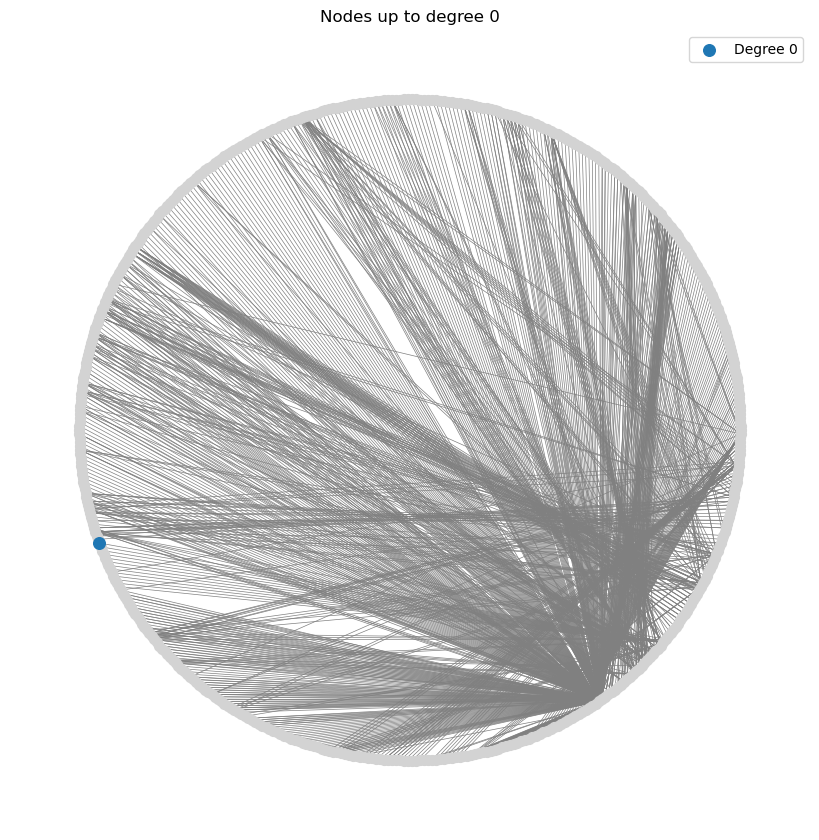

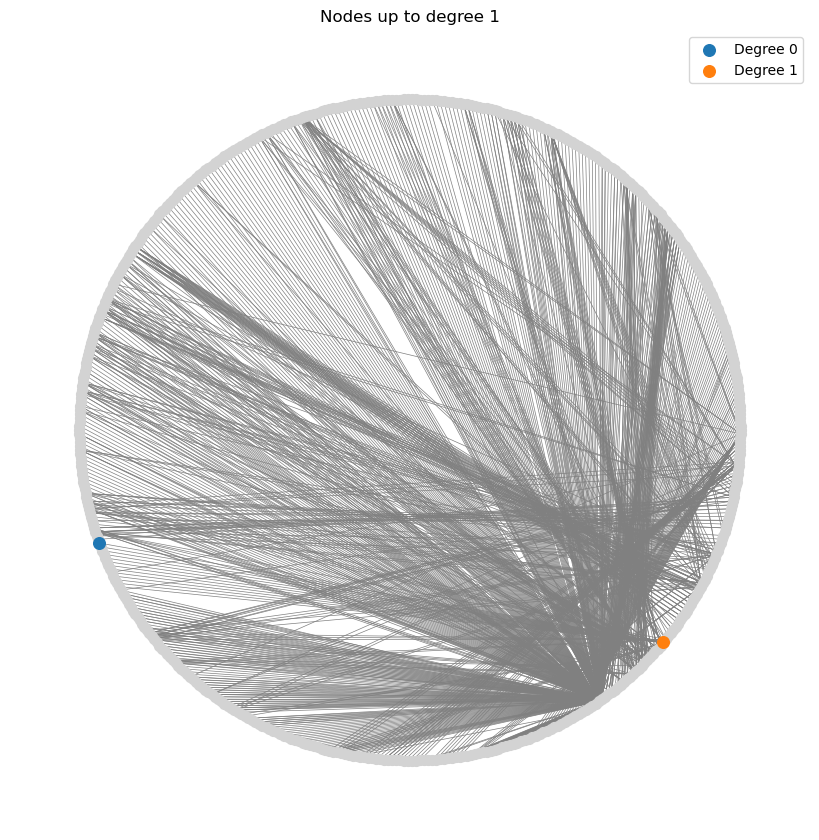

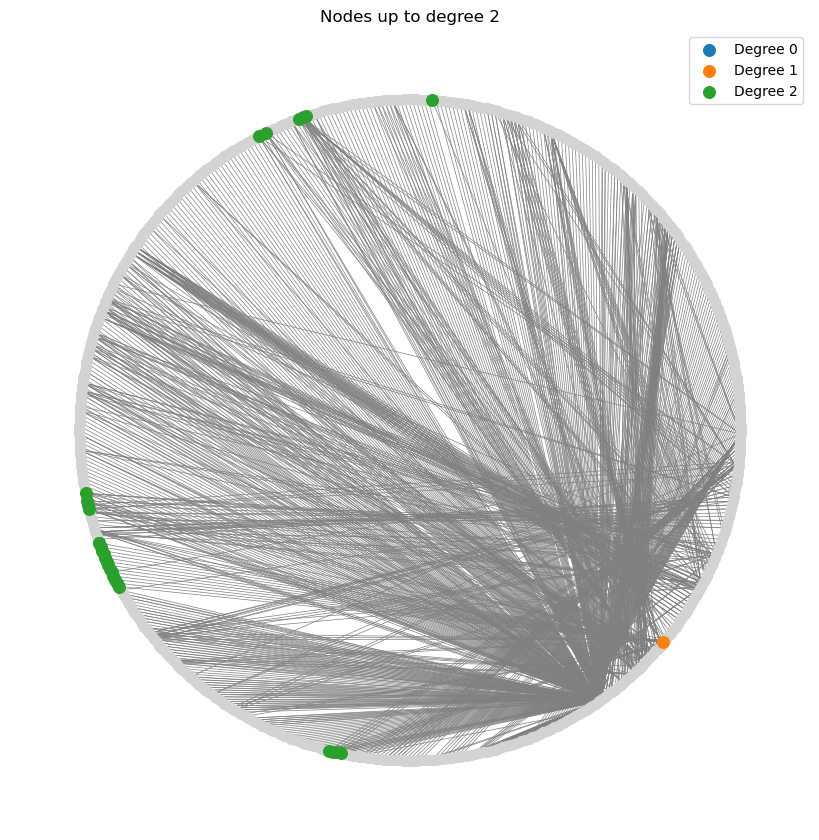

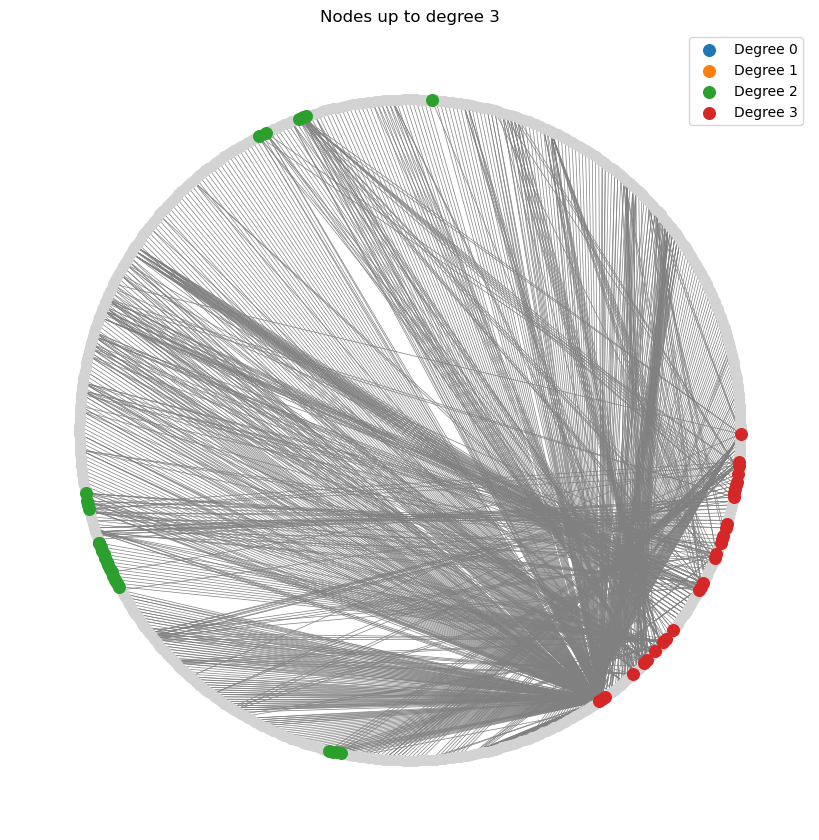

In [120]:
for d in range(max_degree + 1):
    draw_graph_with_highlight(exp_bipartite, neighbors_by_degree, d)